In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
transform_t_to_pil = T.ToPILImage()

### What is the actual goal here?

At a later stage, we want to move images around on a blank canvas. These images are segments of user interfaces. The information where each segment is stored should be stored in a vector containing coordinates for each of the segments on the blank canvas. Lets call it $v$.

Now we want to optimize $v$ to get a higher aesthetic score on the final image (segments on the blank canvas). To do that via an autograd pipeline, we need to find a way to differentiate the aesthetic score $s$ w.r.t. $v$.

This is quite the challenge for a number of reasons:
* "Normal" Array indexing wont work, since this breaks any autograd graphs
* Everything that uses plain integers (instead of floats) as the index is also likely unfeasable, since we only can compute the gradients on floats


In the following, a promising approach is presented, however there is still a challenge to which i dont have a solution right now.

### First Approach
from [https://stackoverflow.com/questions/66987451/image-translation-in-pytorch-using-affine-grid-grid-sample-functions](https://stackoverflow.com/questions/66987451/image-translation-in-pytorch-using-affine-grid-grid-sample-functions)

---
Here we will use [`affine_grid`](https://pytorch.org/docs/stable/generated/torch.nn.functional.affine_grid.html#torch.nn.functional.affine_grid) and [`grid_sample`](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) to move an image around while trying to preserve gradients.

First, we will load one of the UIs of our dataset and extract the first bounding box for this UI:

In [3]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes
"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return [segments,coordinates]

In [4]:
im = Image.open('combined/5373.jpg')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)
with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

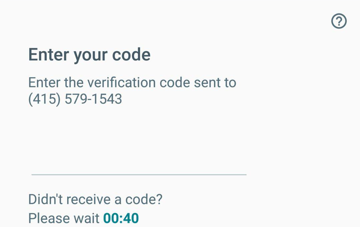

In [5]:
segment_0 =  segment(im,image_json)[0][1]
display(segment_0.resize((int(segment_0.size[0]/4), int(segment_0.size[1]/4))))

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
tensor = transform(im)
dtype =  torch.FloatTensor

Next, we build an affine grid which describes the transformation, which in our case is moving the image to the right. We define a variable `grid_location_x` which we can use to control this. It should be in the range $[-1, 1]$.
In the `rotation_simple` matrix, there are 5 other parameters, which we can use to control y axis moving and rotation around all of the axis.

/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


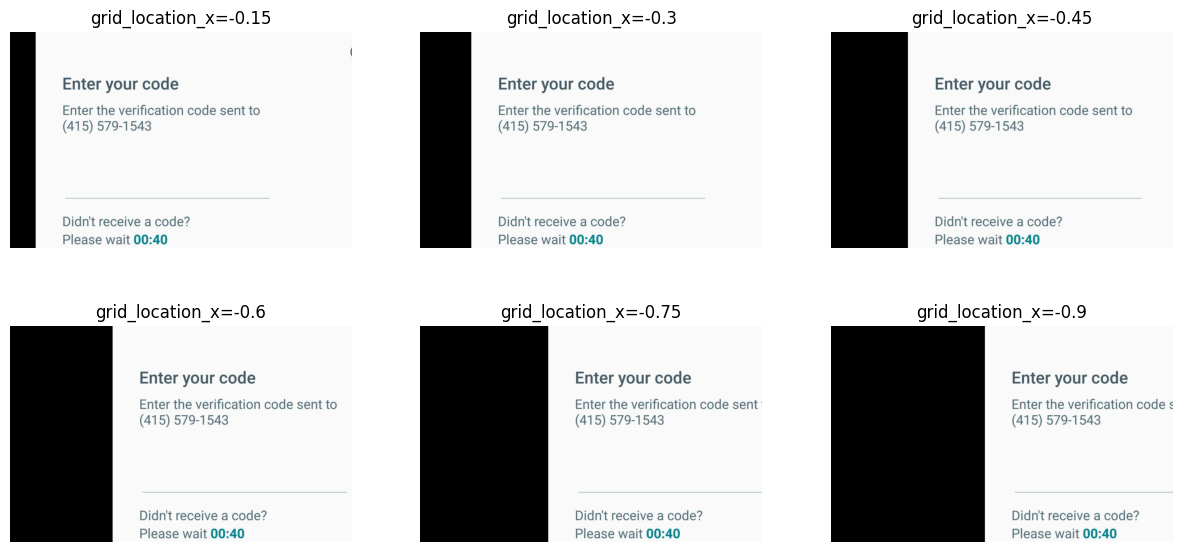

In [7]:
fig = plt.figure(figsize=(15, 7)) 
for n in range(6):
    grid_location_x, grid_location_y = -0.15*(n+1),0.0
    rotation_simple = np.array([[1,0, grid_location_x],
                               [ 0,1, grid_location_y]])
    rotation_simple_tensor = torch.as_tensor(rotation_simple)[None]
    
    grid = F.affine_grid(rotation_simple_tensor, transform(segment_0).unsqueeze(0).size(),align_corners=False).type(dtype)
    
    x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)
    fig.add_subplot(2, 3, n+1) 
    plt.imshow(x[0].permute(1, 2, 0))
    plt.axis('off') 
    plt.title(f"grid_location_x={round(-0.15*(n+1),2)}")

As you can see, we can reliably use this to move an image around. However, the question remains, if we can pass a autograd gradient through this. Lets try this out:

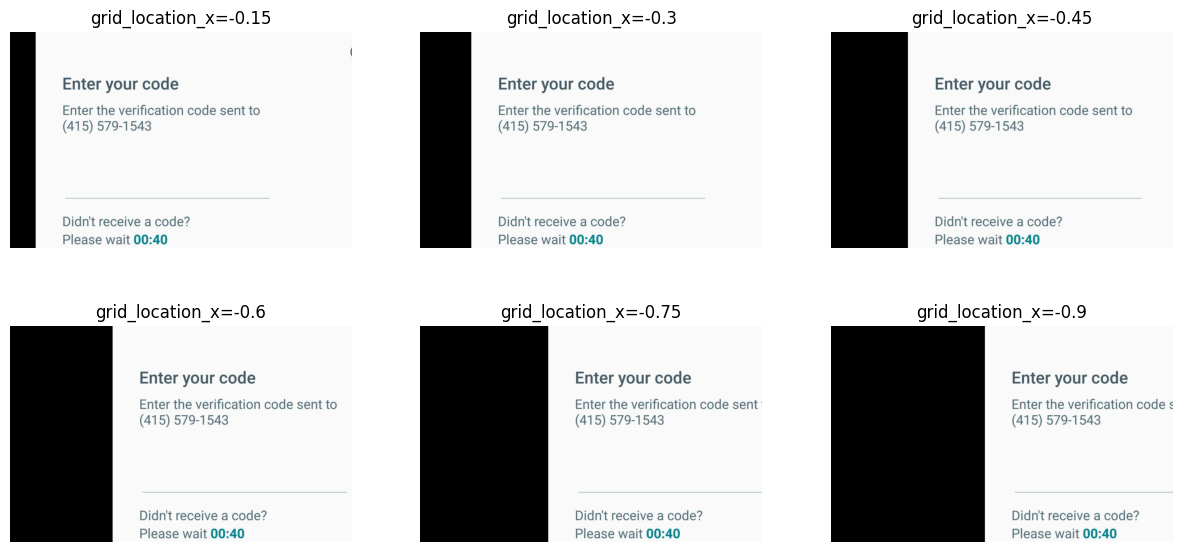

In [8]:
fig = plt.figure(figsize=(15, 7)) 
for n in range(6):
    grid_location_x, grid_location_y = -0.15*(n+1),0.0
    rotation_simple = np.array([[1,0, grid_location_x],
                               [ 0,1, grid_location_y]])
    rotation_simple_tensor = torch.as_tensor(rotation_simple)[None]
    #### Start recording autograd ops
    rotation_simple_tensor.requires_grad_()
    ####
    
    grid = F.affine_grid(rotation_simple_tensor, transform(segment_0).unsqueeze(0).size(),align_corners=False).type(dtype)
    
    x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)

    print(x[0].grad_fn)
    
    fig.add_subplot(2, 3, n+1) 
    plt.imshow(x[0].detach().permute(1, 2, 0))
    plt.axis('off') 
    plt.title(f"grid_location_x={round(-0.15*(n+1),2)}")

Of course we have to call `.detach()` before we pass the image to matplotlib, but this doesnt matter, as you can see, the generated images/matrices still contain the gradient, so this worked!

#### Remaining challenges

While this approach seems promising, some challenges remain. I am currently unsure if it is possible to move a segment on a bigger canvas around and not just on a blank canvas that has the same size as the segment itself.
And even if that would be possible, this is just for one segment, so for multiple segments, we need to layer these transformed images on top of each other, which is probably also a big challenge when wanting to preserve gradients.

#### Test Optimizer
To check the the gradients are actually "real" and not just zero, we will create a simple optimiser which should try to minimise the overall sum of all pixels. This should lead the model to move the image as far out as possible.

Epoch: 0
Parameter containing:
tensor([[1., 0., 0.],
        [0., 1., 0.]], requires_grad=True)


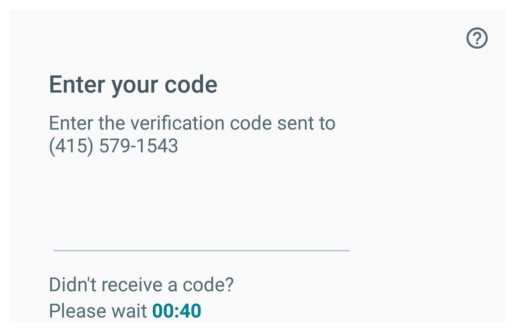

tensor(3780882., grad_fn=<SumBackward0>)
Epoch: 1
Parameter containing:
tensor([[ 1.1707, -0.0070,  0.2155],
        [ 0.0066,  1.1903,  0.1868]], requires_grad=True)


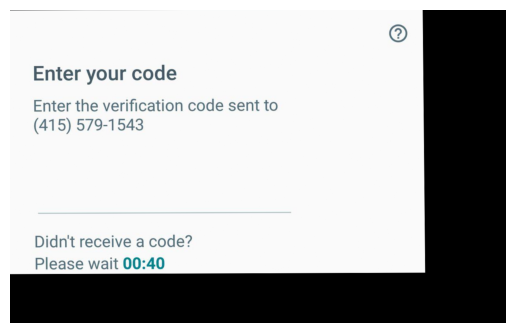

tensor(2649800.2500, grad_fn=<SumBackward0>)
Epoch: 2
Parameter containing:
tensor([[ 1.4124, -0.0379,  0.5473],
        [ 0.0257,  1.5751,  0.3632]], requires_grad=True)


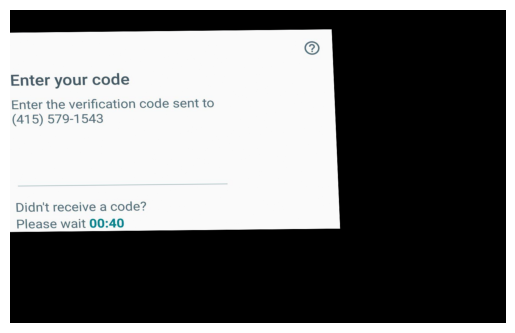

tensor(1575009.8750, grad_fn=<SumBackward0>)
Epoch: 3
Parameter containing:
tensor([[ 1.6547, -0.0855,  0.9310],
        [ 0.0399,  2.0195,  0.5267]], requires_grad=True)


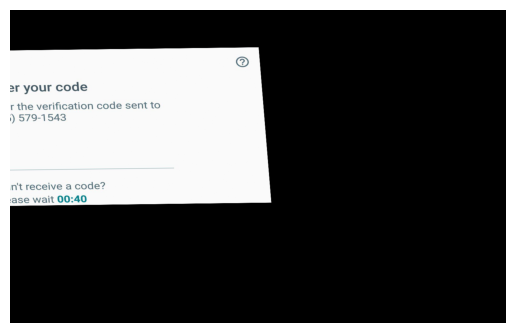

tensor(963494.7500, grad_fn=<SumBackward0>)
Epoch: 4
Parameter containing:
tensor([[ 1.8768, -0.1432,  1.3305],
        [ 0.0537,  2.4667,  0.6758]], requires_grad=True)


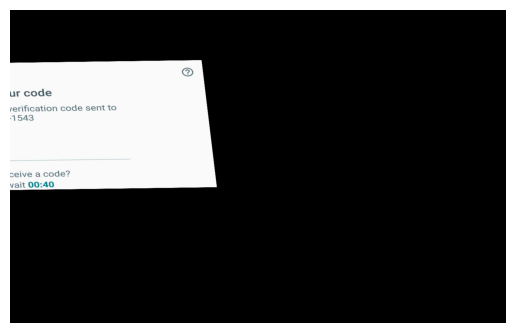

tensor(618225.9375, grad_fn=<SumBackward0>)


In [9]:
class GradientDescent(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rotation_simple = torch.nn.Parameter(torch.tensor([[1,0, 0.0],
                               [ 0,1, 0.0]]))
    
    def forward(self):
        print(self.rotation_simple)
        rotation_simple_tensor = torch.as_tensor(self.rotation_simple)[None]
        grid = F.affine_grid(rotation_simple_tensor, transform(segment_0).unsqueeze(0).size(),align_corners=False).type(dtype)
        x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)
        plt.imshow(x[0].detach().permute(1, 2, 0))
        plt.axis('off') 
        plt.show()
        print(torch.sum(x))
        return torch.sum(x)

gd = GradientDescent()
optimizer_ng = torch.optim.SGD([gd.rotation_simple],lr=1e-7, momentum=0.9)

for x in range(5):
    print(f"Epoch: {x}")
    optimizer_ng.zero_grad()
    loss=gd()
    loss.backward()
    optimizer_ng.step()

The model can control all six of the affine grid parameters, so the image gets a bit warped, but it is obvious that this works.

#### Fixing the "bigger blank canvas" issue

We have a segment with a fixed size:

(360, 227)


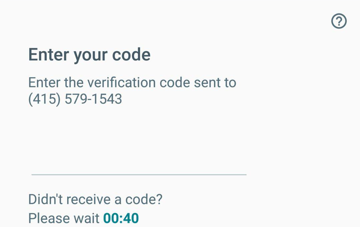

In [10]:
print(segment_0.resize((int(segment_0.size[0]/4), int(segment_0.size[1]/4))).size)
display(segment_0.resize((int(segment_0.size[0]/4), int(segment_0.size[1]/4))))

---
The remaining issue is the following:

The current `affine_grid` and `grid_sample` translation [wikipedia](https://en.wikipedia.org/wiki/Affine_transformation) seems to only work properly, when the 'target' size of the canvas and the size of the segment that we want to move around matches. Otherwise, the image gets warped. 
The following example shows what happens when the canvas is twice as big in the $y$ dimension:

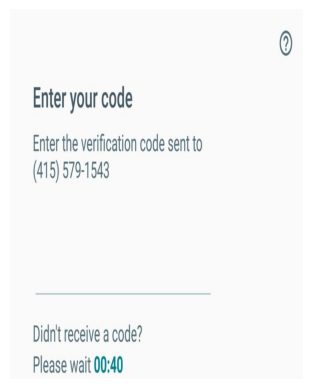

In [43]:
n=2
grid_location_x, grid_location_y = 0.0,0.0
rotation_simple = np.array([[1,0, grid_location_x],
                           [ 0,1, grid_location_y]])
rotation_simple_tensor = torch.as_tensor(rotation_simple)[None]

canvas_size = (1,3,1818,1440) # Twice the height of the original image

grid = F.affine_grid(rotation_simple_tensor, canvas_size, align_corners=True).type(dtype)
x = F.grid_sample(transform(segment_0).unsqueeze(0), grid, align_corners=True)
plt.imshow(x[0].permute(1, 2, 0).detach())
plt.axis('off') 
plt.show()

However, this was a misunderstanding on my part of the answer in [the original stackoverflow question](https://stackoverflow.com/questions/66987451/image-translation-in-pytorch-using-affine-grid-grid-sample-functions), where the user states that the values for the translation have to be in the interval $[-1,1]$. I misunderstood this as all of the values in the affine matrix having to be in this interval.
After looking at the [wikipedia page](https://en.wikipedia.org/wiki/Affine_transformation) for the Affine transformation, i realised that this doesnt make any sense. So what we can do, is modifying both $x$ and $y$ coordinates as well as the transformation of the segment into a bigger canvas. To do this, we "counteract" the warp, by just scaling the segment via our $\theta$.
If we want to put our segment on to a canvas that is twice as wide and four times as high, we can just scale the segment by these ratios through the affine matrix:
Identity affine matrix:

$
\theta_1 = 
\begin{bmatrix}
1.0 & 0.0 & 0.0 \\
0.0 & 1.0 & 0.0
\end{bmatrix}
$

Scaling affine matrix for 2-times wide and 4-times high:

$
\theta_2 = 
\begin{bmatrix}
2.0 & 0.0 & 0.0 \\
0.0 & 4.0 & 0.0
\end{bmatrix}
$

If we apply this new $\theta$ to our `grid_sample`, we can see that this does what we expect:

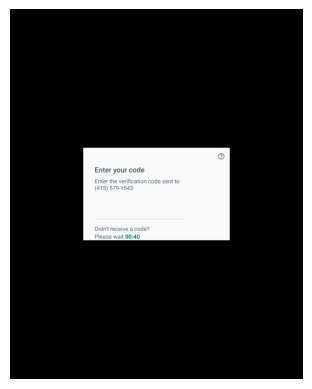

In [55]:
theta = np.array([
    [2.0, 0.0, 0.0],
    [0.0, 4.0, 0.0]
])
theta_tensor = torch.as_tensor(theta)[None]
canvas_size = (1,3,3636,2880)

grid = F.affine_grid(theta_tensor, canvas_size).type(dtype)
x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)

plt.imshow(x[0].permute(1, 2, 0).detach())
plt.axis('off') 
plt.show()

And we can still move the image around in our canvas:

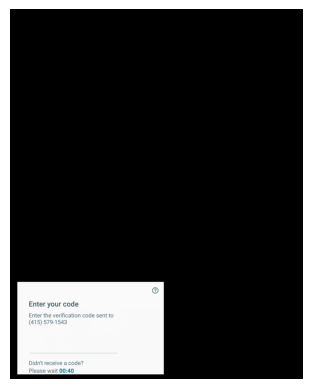

In [66]:
theta = np.array([
    [2.0, 0.0,  0.9],
    [0.0, 4.0, -2.9]
])
theta_tensor = torch.as_tensor(theta)[None]
canvas_size = (1,3,3636,2880)

grid = F.affine_grid(theta_tensor, canvas_size).type(dtype)
x = F.grid_sample(transform(segment_0).unsqueeze(0), grid)

plt.imshow(x[0].permute(1, 2, 0).detach())
plt.axis('off') 
plt.show()